# emcee hammer sampler logistic example
This example demonstrates how to use the emcee hammer MCMC sampler [1] to sample from the posterior of the logistic model. This sampler evolves multiple 'walkers' in parallel, where the position of the Kth walker is based on the position of the (K-1) walkers in the complementary ensemble.

Here we wrap the implementation of the sampler by the paper author's (see http://dfm.io/emcee/current/) in a Pints module so that it works out of the box with Pints functionality.

[1] "emcee: The MCMC Hammer", Daniel Foreman-Mackey, David W. Hogg, Dustin Lang, Jonathan Goodman, https://arxiv.org/abs/1202.3665.

In [5]:
import numpy as np
import emcee

In [10]:
def lnprob(x, mu, icov):
    diff = x-mu
    return -np.dot(diff,np.dot(icov,diff))/2.0

ndim = 10

means = np.random.rand(ndim)

cov = 0.5 - np.random.rand(ndim ** 2).reshape((ndim, ndim))
cov = np.triu(cov)
cov += cov.T - np.diag(cov.diagonal())
cov = np.dot(cov,cov)

icov = np.linalg.inv(cov)
nwalkers = 250
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[means, icov])
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.run_mcmc(pos, 1000)

(array([[ 0.18241945,  1.1072302 , -0.3878961 , ...,  1.01791557,
          0.43058247,  0.5940146 ],
        [ 0.88791472,  0.63842637,  0.93050153, ..., -0.02213822,
         -0.28696846,  1.64350631],
        [ 0.66211584,  2.6175048 , -0.1686231 , ...,  2.0937694 ,
          0.78129368,  0.66605836],
        ..., 
        [ 0.40726821,  0.93967314,  0.37589475, ...,  0.44609276,
          0.79475218,  0.89901827],
        [-0.08492134,  0.65851663, -1.15331702, ..., -0.07170644,
          1.20783012, -0.20735587],
        [ 1.02240945,  1.6538332 ,  1.03367063, ...,  0.46165531,
         -0.43684677,  0.00968094]]),
 array([ -3.16517716,  -4.46713104,  -4.36856112,  -5.97983053,
         -4.02391989,  -4.13516715,  -5.1846133 ,  -7.94448295,
         -4.80564928,  -5.99855252,  -4.30591363,  -2.81749243,
         -3.73468695,  -3.01034844,  -2.74819735,  -4.52542489,
         -6.4592564 ,  -4.40738089,  -5.13203669,  -2.91558874,
         -9.09947689,  -3.61636195,  -2.72200617,  -

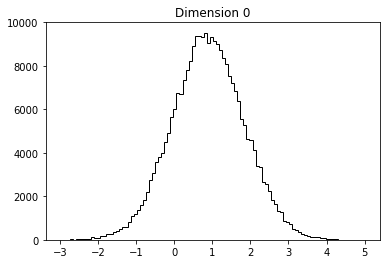

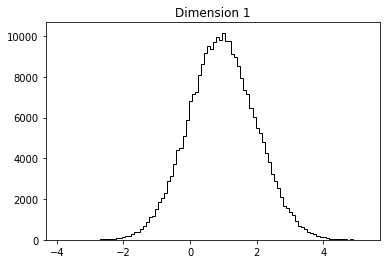

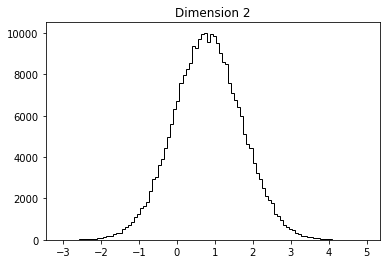

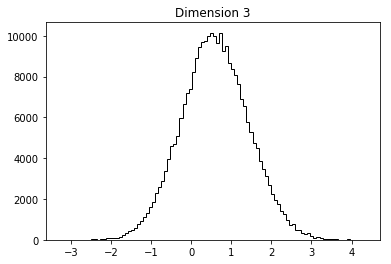

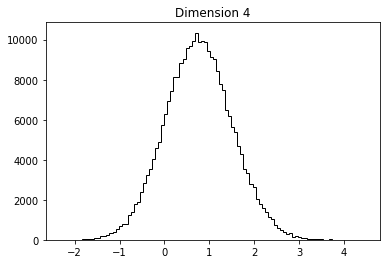

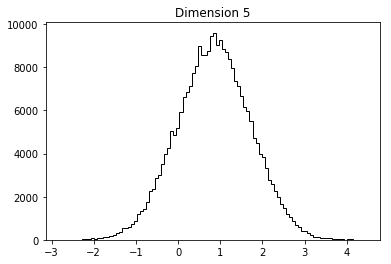

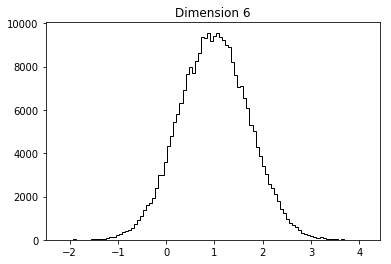

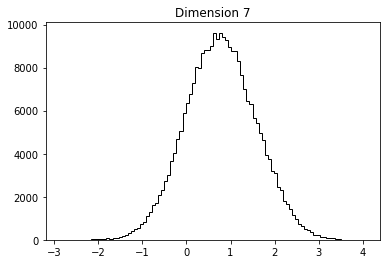

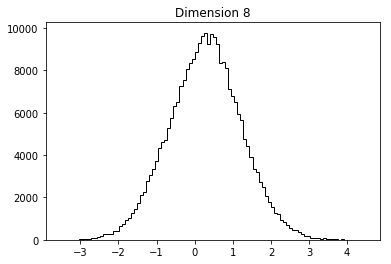

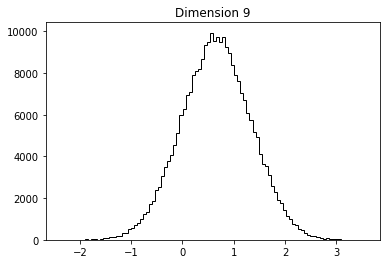

In [11]:
import matplotlib.pyplot as pl

for i in range(ndim):
    pl.figure()
    pl.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    pl.title("Dimension {0:d}".format(i))

pl.show()

In [13]:
import pints
from __future__ import print_function
import pints
import pints.toy as toy

# Load a forward model
model = toy.LogisticModel()

In [14]:
model

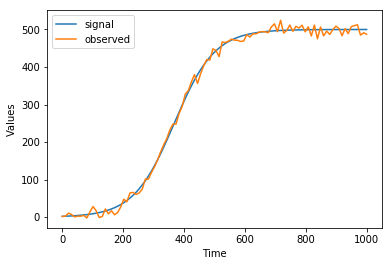

In [26]:
import pints
from __future__ import print_function
import pints
import pints.toy as toy
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
r = 0.015
k = 500
real_parameters = [r, k]
times = np.linspace(0, 1000, 100)
signal_values = model.simulate(real_parameters, times)

# Add independent Gaussian noise
sigma = 10
observed_values = pints.noise.add_independent_noise(signal_values,sigma)

# Plot
plt.plot(times,signal_values,label = 'signal')
plt.plot(times,observed_values,label = 'observed')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

In [63]:
# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, observed_values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

In [28]:
log_likelihood([0.015,500,2])

-380.14365889142687

In [64]:
nwalkers = 10
p0 = [[0.015 + 1e-4*np.random.randn(1)[0],500 + np.random.randn(1)[0],10 + np.random.randn(1)[0]] for i in range(nwalkers)]
p0

[[0.015014820653132508, 500.66419223259265, 10.077924661618543],
 [0.015024603679031278, 500.14597473436976, 9.0765829128268525],
 [0.015123551629215087, 500.29953999706015, 9.3970497659658321],
 [0.015242065610080254, 500.50500858100202, 11.314015015763619],
 [0.01492770359485392, 500.79176660528299, 10.901831576625165],
 [0.014864294072833118, 500.94354292020864, 8.940470871922189],
 [0.014893547331438432, 499.88043571888005, 9.0953758880144679],
 [0.014955364919377052, 499.0752357546192, 11.085276536075977],
 [0.014978984211414328, 500.84532594135067, 8.9249691367709083],
 [0.015093523184492502, 500.05033822465117, 11.830172675149914]]

In [65]:
sampler = emcee.EnsembleSampler(nwalkers, 3, log_likelihood)
pos, prob, state = sampler.run_mcmc(p0, 1000)
pos, prob, state = sampler.run_mcmc(pos, 1000)
pos

array([[  1.49930731e-02,   4.99575060e+02,   9.10404187e+00],
       [  1.50686763e-02,   4.98256757e+02,   9.37077855e+00],
       [  1.49894843e-02,   4.97973479e+02,   8.48829702e+00],
       [  1.50173858e-02,   4.99710648e+02,   1.01921901e+01],
       [  1.50435282e-02,   4.98147668e+02,   1.04031784e+01],
       [  1.50256645e-02,   5.01180921e+02,   1.23913495e+01],
       [  1.50754397e-02,   4.98594007e+02,   1.04139475e+01],
       [  1.50754990e-02,   4.98020832e+02,   1.08161161e+01],
       [  1.50078109e-02,   4.97543428e+02,   1.01664520e+01],
       [  1.49156706e-02,   4.99403536e+02,   9.93297821e+00]])

In [70]:
sampler.chain.shape

(10, 2000, 3)

In [54]:
print("Mean acceptance fraction: {0:.3f}"
                .format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.648


In [68]:
samples = sampler.chain[:, 50:, :].reshape((-1, 3))

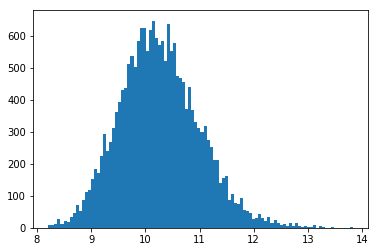

In [69]:
plt.hist(samples[:,2],100)
plt.show()

In [1]:
from __future__ import print_function
import pints
import pints.toy as toy
import pints._diagnostics as diagnostics
import numpy as np
import matplotlib.pyplot as pl

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleSeriesProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
prior = pints.UniformPrior(
    [0.01, 400, noise*0.1],
    [0.02, 600, noise*100]
    )

# Create a Bayesian log-likelihood (prior * likelihood)
log_likelihood = pints.LogPosterior(prior, log_likelihood)

# Create an adaptive covariance MCMC routine
x0 = real_parameters * 1.1
mcmc = pints.EmceeHammerMCMC(log_likelihood, x0)

In [2]:
# Run!
print('Running...')
chain = mcmc.run()
print('Done!')

Running...
Running emcee hammer MCMC
Total number of iterations: 6000
Number of iterations to discard as burn-in: 3000
Storing one sample per 1
[  1.65000000e-02   5.50000000e+02   1.10000000e+01] [[  1.65000000e-04   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   5.50000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   1.10000000e-01]]
Done!


In [5]:
samples = chain.reshape((-1, 3))